<h1><center>Uncertainty Quantification in Machine Learning</center></h1>

<h3><center>Special problem</center></h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from scipy.stats import f
from numpy.random import default_rng

# Useful functions

In [5]:
def gen_dataset(X1,y1,X2,y2,decimal):
    X_labeled_1 = np.vstack((X1,y1)).T.round(decimal)
    X_labeled_2 = np.vstack((X2,y2)).T.round(decimal)
    return np.vstack((X_labeled_1,X_labeled_2))
    

def gauss(mu,sigma,x):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x - mu)**2 / (2 * sigma**2)) 


def gaussian(N_points,decimal,mu_1,sigma_1,mu_2,sigma_2):  
    X1 = np.random.normal(mu_1,sigma_1,N_points)
    y1 = -np.ones(N_points)
    X2 = np.random.normal(mu_2,sigma_2,N_points)
    y2 = np.ones(N_points)

    X_final = gen_dataset(X1,y1,X2,y2,decimal)

    return X1,X2,X_final


def uniform(N_points,decimal,a_1,b_1,a_2,b_2):
    X1 = np.random.uniform(a_1,b_1,N_points)
    y1 = -np.ones(N_points)
    X2 = np.random.uniform(a_2,b_2,N_points)
    y2 = np.ones(N_points)

    X_final = gen_dataset(X1,y1,X2,y2,decimal)

    return X1,X2,X_final


def calcul_unc(n_test,mu,sigma,t,D):
    unc = np.zeros((n_test,len(t)))
    l_list = []

    for k in range(n_test):
        unc_t = np.zeros(len(t))
        l = np.random.normal(size=1,loc=mu,scale=sigma)[0]
        l_list.append(l)

        for sample in D:
            x = sample[0]
            y = sample[1]
            
            if x<=-1 or x>=1:
                pass

            elif x < l:
                if y==1:
                    unc_t[t.index(x)]+=1
            else:
                if y==-1:
                    unc_t[t.index(x)]+=1
        
        unc[k,:] = unc_t/(10*len(t))

    mean_unc = np.mean(unc,axis=0)
    std_unc = np.std(unc,axis=0)
    
    return unc, mean_unc, std_unc, l_list


def plot_unc(unc,t,title):
    N,P = unc.shape
    for k in range(N):
        plt.plot(t,unc[k,:])

    plt.xlim(-1,1)
    plt.title(title)
    plt.show()


def error_bar_plot(mean_unc,std,t,title):
    plt.plot(t,mean_unc,linewidth=4)
    plt.errorbar(t,mean_unc,yerr = std,linewidth=1)
    plt.title(title)
    plt.show()


def detect_outliers(X,A,max_k):
    X = preprocessing.scale(X)
    N = X.shape[0]

    pca = PCA(n_components=A)
    pca.fit(X)

    loadings_p = pca.components_.T
    eigenvalues = pca.explained_variance_

    hotelling_t2s = np.array([xi.dot(loadings_p)
                                .dot(np.diag(eigenvalues ** -1))
                                .dot(loadings_p.T)
                                .dot(xi.T)
                            for xi in X])

    F95 = A*(N**2 - 1)/(N*(N - A)) * f.ppf(0.95,A,N-A)
    F99 = A*(N**2 - 1)/(N*(N - A)) * f.ppf(0.99,A,N-A)

    L99 = []
    for i,t2 in enumerate(hotelling_t2s):
        if t2>F99:
            L99.append(i)

    NN = NearestNeighbors(n_neighbors=max_k).fit(X)
    distances, indices = NN.kneighbors(X)

    distanceDec = sorted(distances[:,max_k-1],reverse=True)

    EPS = np.percentile(distanceDec,99)
    clustering = DBSCAN(eps=EPS,min_samples=3).fit(X)

    y_pred = pd.Series(clustering.labels_.tolist())

    L_clust = []
    for i,x in enumerate(list(y_pred)):
        if x!=0:
            L_clust.append(i)

    outliers = set(L99).union(L_clust)

    return outliers


def fisher(lam,N):
    s = 0

    for i in range(N):
        for j in range(N):
            s += (lam[i]**2)*(lam[j]**2)

    return (N**4)*(N-1)/(4*s)

# Samples creation

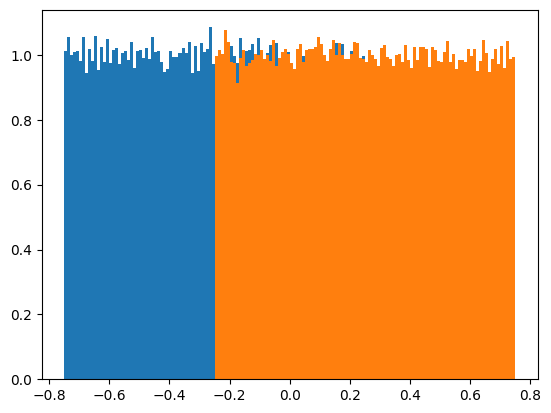

In [6]:
rng = default_rng(42)
N_p_uniform = 10**5
decimal = 2
a_1,b_1 = -0.75,0.25
a_2,b_2 = -0.25,0.75

X1_uni,X2_uni,D_uni = uniform(N_p_uniform,decimal,a_1,b_1,a_2,b_2)

count_1_uni, bins_1_uni, ignored_1_uni = plt.hist(X1_uni, 100, density=True)
count_2_uni, bins_2_uni, ignored_2_uni = plt.hist(X2_uni, 100, density=True)

plt.show()

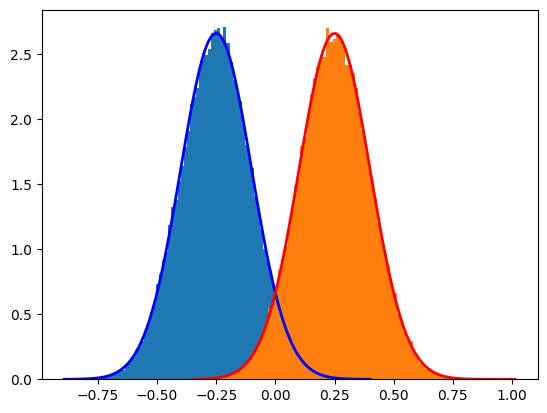

In [7]:
rng = default_rng(42)
N_p_gauss = 10**5
decimal = 2
mu_1,sigma_1 = -0.25,0.15
mu_2,sigma_2 = 0.25,0.15

X1_gauss,X2_gauss,D_gauss = gaussian(N_p_gauss,decimal,mu_1,sigma_1,mu_2,sigma_2)

count_1_gauss, bins_1_gauss, ignored_1_gauss = plt.hist(X1_gauss, 100, density=True)
count_2_gauss, bins_2_gauss, ignored_2_gauss = plt.hist(X2_gauss, 100, density=True)

plt.plot(bins_1_gauss, gauss(mu_1,sigma_1,bins_1_gauss),linewidth=2, color='b')
plt.plot(bins_2_gauss, gauss(mu_2,sigma_2,bins_2_gauss),linewidth=2, color='r')
plt.show()

# Uncertainty in the uniform case

In [8]:
n_test = 100
mu,sigma = 0,0.1
decimal = 2
t = list(np.arange(-1,1,10**(-decimal)).round(decimal))

unc_uni,mean_unc_uni,std_unc_uni,lambda_uni = calcul_unc(n_test,mu,sigma,t,D_uni)

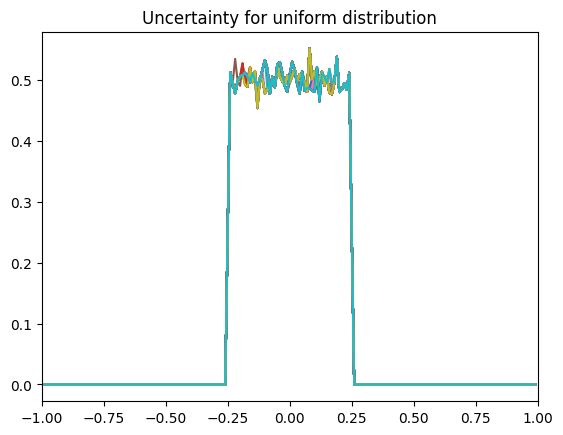

In [41]:
title_uni = "Uncertainty for uniform distribution"
plot_unc(unc_uni,t,title_uni)

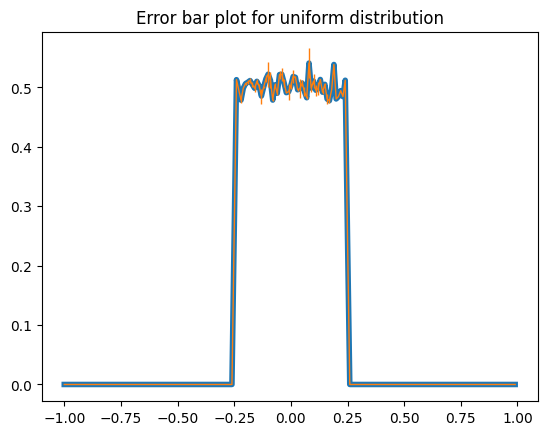

In [42]:
title_err_uni = "Error bar plot for uniform distribution"
error_bar_plot(mean_unc_uni,std_unc_uni,t,title_err_uni)

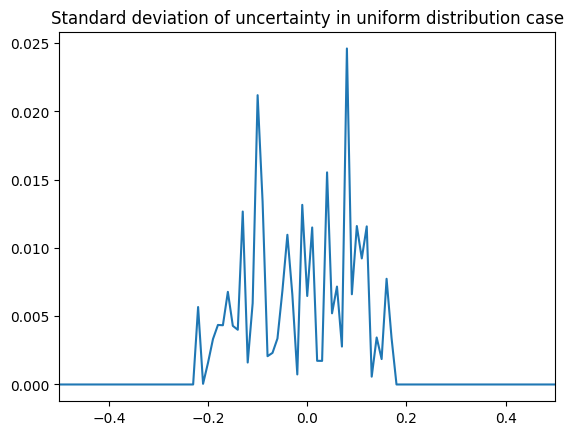

In [43]:
plt.plot(t,std_unc_uni)
plt.xlim(-0.5,0.5)
plt.title("Standard deviation of uncertainty in uniform distribution case")
plt.show()

In [9]:
fisher_uni = fisher(lambda_uni,n_test)
1/fisher_uni

3.980242134859097e-10

# Uncertainty in the gaussian case

In [10]:
n_test = 100
mu,sigma = 0,0.1
decimal = 2
t = list(np.arange(-1,1,10**(-decimal)).round(decimal))

unc_gauss,mean_unc_gauss,std_unc_gauss,lambda_gauss = calcul_unc(n_test,mu,sigma,t,D_gauss)

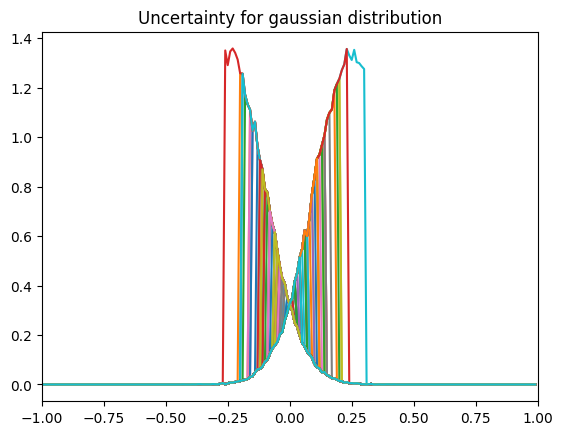

In [21]:
title_gauss = "Uncertainty for gaussian distribution"
plot_unc(unc_gauss,t,title_gauss)

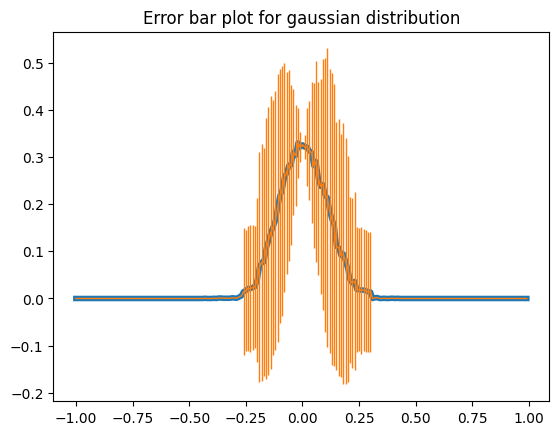

In [22]:
title_err_gauss = "Error bar plot for gaussian distribution"
error_bar_plot(mean_unc_gauss,std_unc_gauss,t,title_err_gauss)

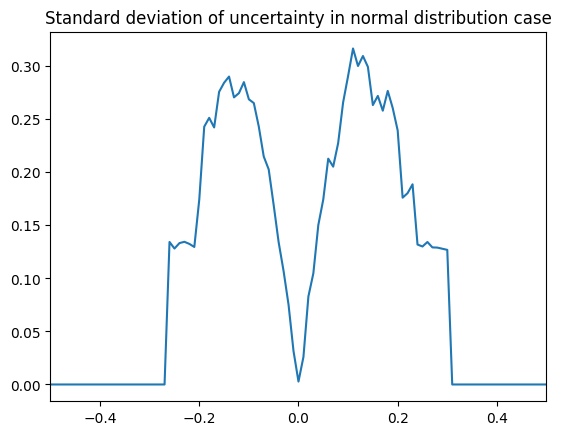

In [23]:
plt.plot(t,std_unc_gauss)
plt.xlim(-0.5,0.5)
plt.title("Standard deviation of uncertainty in normal distribution case")
plt.show()

In [11]:
fisher_gauss = fisher(lambda_gauss,n_test)
1/fisher_gauss

2.3169135765420645e-10